In [18]:
from langgraph.graph import StateGraph,START,END,MessagesState
from langchain_openai import ChatOpenAI
from typing import TypedDict,Literal,Annotated
from dotenv import load_dotenv
from pydantic import BaseModel,Field
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage,HumanMessage,BaseMessage
from langgraph.checkpoint.memory import InMemorySaver

In [19]:
from langchain.messages import RemoveMessage

In [20]:
load_dotenv()

True

In [21]:
llm=ChatOpenAI()

In [29]:
from langgraph.graph.message import RemoveMessage

def chat_node(state: MessagesState):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}


def delete_old_messages(state: MessagesState):
    msgs = state["messages"]

    if len(msgs) > 10:
        to_remove = msgs[:6]
        return {
            "messages": [RemoveMessage(id=m.id) for m in to_remove]
        }

    return {}


In [30]:
checkpointer=InMemorySaver()

In [31]:
graph=StateGraph(MessagesState)

graph.add_node('chat node',chat_node)
graph.add_node('cleanup',delete_old_messages)

graph.add_edge(START,'chat node')
graph.add_edge('chat node','cleanup')#run deleteion after each run
graph.add_edge('cleanup',END)

graph=graph.compile(checkpointer=checkpointer)

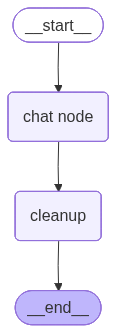

In [32]:
graph

In [33]:
config={"configurable":{"thread_id":"thread_123"}}

In [34]:
graph.invoke({"messages": [{"role": "user", "content": "Hi, I'm Nitish"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "Tell me about LangGraph"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "Now explain checkpointers"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "What is Langchain"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "What is Quantum Mechanics"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "What is Gen AI"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "What is my name"}]}, config)

{'messages': [HumanMessage(content='What is Langchain', additional_kwargs={}, response_metadata={}, id='2eff4957-f228-4e96-b4c2-04e4e7c42ab2'),
  AIMessage(content='I am not familiar with LangChain. Could you provide more context or information to help me better understand what LangChain is or refer to?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 263, 'total_tokens': 291, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-D2dsirRj5qovdTJ2C3emhBDeoRuKk', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019bffbf-fe4a-7202-b410-2c922ed3bff2-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 263, 'output_

In [35]:

snap = graph.get_state(config)
print("Stored messages after cleanup:", len(snap.values["messages"]))

Stored messages after cleanup: 8
